In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import radon
import torch.nn as nn
import torch.functional as F

## Utilize the GPU using CUDA

In [3]:
# CUDA for PyTorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce GTX 1660 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Step1_Data required for model training

In [5]:
# transform = transforms.Compose(transforms.ToTensor())
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [13]:
## MNIST Data
n_samples = 100
train_data = datasets.MNIST(root = './data', train = True, download = True).data / 255
test_data = datasets.MNIST(root = './data', train = False, download = True).data / 255
train_data.is_cuda, test_data.is_cuda

(False, False)

In [14]:
train_data.shape

torch.Size([60000, 28, 28])

## Radon matrix construction 

In [7]:
# Radon Matrix exists for every angle and every line. matrix 
def getRadonMatrix(theta,ny,nx):
    colum_of_A = radon(np.zeros((ny,nx)), theta = theta) # this is only to know the size
    A = np.zeros((colum_of_A.size, nx*ny))
    for i in range(ny):
        for j in range(nx):
            basis_vec = np.zeros((ny,nx))
            basis_vec[i,j] = 1
            colum_of_A = radon(basis_vec, theta = theta)
            A[:,j+i*nx] = np.reshape(colum_of_A, colum_of_A.size)
    return torch.from_numpy(A).double()

In [16]:
nx, ny = train_data[1].shape 

# theta values for X ray incidence angles
theta = np.linspace(0,180,14,endpoint = True)

# call getRadonMatrix
A = getRadonMatrix(theta, ny, nx)
pinv_A = torch.from_numpy(np.linalg.pinv(A)).double()

C:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


##  Noisy Sinogram vector using Radon matrix

In [17]:
def sinogram(image_data):
    sino_gram = image_data @ A.T
    noise_level = 0.01 
    sino_gram += noise_level * torch.randn(sino_gram.shape)
    return sino_gram.double()

In [25]:
train_data.type

<function Tensor.type>

In [19]:
train_data = np.reshape(train_data, (train_data.shape[0],train_data.shape[1]*train_data.shape[2]))
sinogram_train = sinogram(train_data.double())
test_data = np.reshape(test_data, (test_data.shape[0],test_data.shape[1]*test_data.shape[2]))
sinogram_test = sinogram(test_data.double())
train_data.is_cuda, sinogram_train.is_cuda 

(False, False)

In [22]:
sinogram_shape = sinogram_train.shape
sinogram_shape

torch.Size([60000, 392])

## Dataloader to try batches of data

In [23]:
sinogram_train = sinogram_train.to(device)
train_data = train_data.to(device)
dataset_train = TensorDataset(sinogram_train.double(), train_data.double())
train_data.shape

torch.Size([60000, 784])

In [24]:
# train_loader = DataLoader(dataset = (sinogram_train, train_data), batch_size=20, shuffle=False)
batch_size=20
train_loader = DataLoader(dataset = dataset_train, batch_size = 20, shuffle=False)

## Step2_Network architecture

In [40]:
class my_network(nn.Module):
    def __init__(self):
        super(my_network, self).__init__()
   
        hidden = 4
    
        # self.fc1 = nn.Linear(A.size()[1], hidden)
        self.conv1image = nn.Conv2d(1, hidden, 3, padding=1)
        self.conv2image = nn.Conv2d(hidden,1, 3, padding=1)
        self.conv1sino = nn.Conv2d(1, hidden, 3, padding=1)
        self.conv2sino = nn.Conv2d(hidden,1, 3, padding=1)
        # self.fc2 = nn.Linear(hidden, A.size()[1])
        
    def forward(self,sinogram,A, pinv_A, maxiter, tau):
        # A needs to be of dimension: (sinogram_dimension x image_pixels)
        # sinogram will be of dimension: (number_of_examples (batchsize)  x  sinogram_dimension) 
        output = (sinogram @ pinv_A.T).double()
        for i in range(maxiter):    
            # possible here: Design a small sinogramCNN on err!
            batch_size = sinogram.shape[0]
            err = (output @ A.T - sinogram)
            err = torch.reshape(err,(batch_size,1,len(theta),ny))
            err = self.conv2sino(nn.functional.relu(self.conv1sino(err)))
            err = torch.reshape(err,(batch_size,len(theta) * ny))
            intermediateoutput = output - tau * err @ A
            intermediateoutput = torch.reshape(intermediateoutput,(batch_size,1, nx, ny))
            output = self.conv2image(nn.functional.relu(self.conv1image(intermediateoutput)))
            output = torch.reshape(output,(batch_size, nx * ny))
            
            
            # in the above notation imageSpaceCNN = self.conv2(nn.functional.relu(self.conv1( * )))
        
        output = torch.reshape(output,(batch_size, 1, nx , ny))
        # weights for sharpening the image from "https://setosa.io/ev/image-kernels/"
        # https://discuss.pytorch.org/t/setting-custom-kernel-for-cnn-in-pytorch/27176/3
        weights = torch.tensor([[0., -1., 0.],
                                [-1., 5., -1.],
                                [0., -1., 0.]], requires_grad = False)
        weights = weights.view(1, 1, 3, 3).repeat(1, 1, 1, 1) / 4
        sharpening_conv = nn.Conv2d(1, 1, 3, bias=False)
        with torch.no_grad():
            sharpening_conv.weight = nn.Parameter(weights)
        sharpening_conv.weight.requires_grad = False
        output = torch.reshape(output,(batch_size, nx * ny))
        
        return output

## Step3_Model ingredients

In [41]:
maxiter = 5
tau = 0.01
model = my_network()
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3) # stochastic gradient descent - torch.optim.SGD
model = model.double()
# Transferring the model to a CUDA enabled GPU
model = model.to(device)

## Step4_Model Training - forward, backward, weight updates

In [42]:
# store everything needed for model in GPU
A = A.to(device)
pinv_A = pinv_A.to(device)
# maxiter = maxiter.to(device)
# tau = tau.to(device)

number_of_epochs = 5
for epoch in range(number_of_epochs+1):
    
    for sinogram_input, image_target in train_loader:
        # forward pass and loss
        prediction = model(sinogram_input, A, pinv_A, maxiter, tau)
        loss = criterion(prediction, image_target)

        # backward pass - gradients calculated here
        loss.backward()

        # update parameters
        optim.step()
        
        # If not use zero_grad() =>> the loss will increase not decrease as required.
        # So, to zero the gradients in before iteration =>>
        optim.zero_grad()
        
    if epoch%1 == 0:
        print(loss)

tensor(0.0015, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0009, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0007, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0007, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


In [18]:
for name, param in model.parameters():

<generator object Module.parameters at 0x0000020CA3A8CE40>

## Step5_Plotting results

Text(0.5, 1.0, 'pseudo_inversed_image')

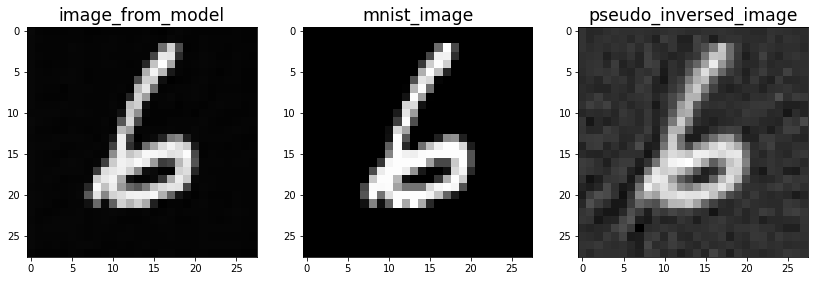

In [43]:
## all data to be in numpy arrays in cpu to plot using matplotlib.pyplot
sinogram_from_radon = sinogram_input.cpu().detach().numpy()
reconstruction = prediction.cpu().detach().numpy()
imageTarget = image_target.cpu().detach().numpy()
pseudo_inversed_image = sinogram_from_radon @ np.linalg.pinv(A.T.cpu().detach().numpy())

f, axis = plt.subplots(nrows = 1,ncols = 3,sharex=True, figsize=(14,6), squeeze=True)

axis[0].imshow(np.reshape(reconstruction[1], (ny,nx)), cmap='gray')
axis[0].set_title('image_from_model', fontsize="xx-large")
# axis[1].imshow(np.reshape(sinogram_from_radon[1], (14,nx)), cmap='gray')
# axis[1].set_title('sinogram_from_radon', fontsize="xx-large")
# axis[1].set_ylabel('no_of_theta', fontsize="xx-large")
# axis[1].set_xlabel('nx', fontsize="xx-large")
axis[1].imshow(np.reshape(imageTarget[1], (ny,nx)), cmap='gray')
axis[1].set_title('mnist_image', fontsize="xx-large")
axis[2].imshow(np.reshape(pseudo_inversed_image[1], (ny,nx)), cmap='gray')
axis[2].set_title('pseudo_inversed_image', fontsize="xx-large")

## Step6_Save the model

In [20]:
torch.save(model.state_dict(), './model_cnn_without_customkernel')

## Step7_test the model with testing data

In [44]:
sinogram_test = sinogram_test.to(device)
test_data = test_data.to(device)
A = A.to(device)
pinv_A = pinv_A.to(device)
# dataset_test = TensorDataset(sinogram_test.double(), test_data.double())
# test_loader = DataLoader(dataset = dataset_test, batch_size = 20, shuffle=False)
# sinogram_train.shape

prediction = model(sinogram_test, A, pinv_A, maxiter, tau)
loss = criterion(prediction, image_target)
print(total_loss)

RuntimeError: CUDA out of memory. Tried to allocate 240.00 MiB (GPU 0; 6.00 GiB total capacity; 4.05 GiB already allocated; 0 bytes free; 4.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Text(0.5, 1.0, 'pseudo_inversed_image')

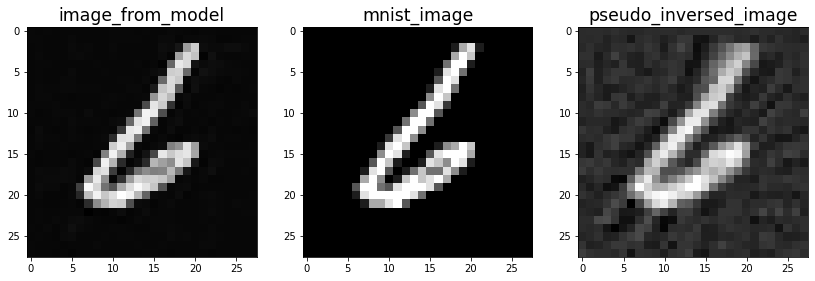

In [90]:
## all data to be in numpy arrays in cpu to plot using matplotlib.pyplot
sinogram_from_radon = sinogram_input.cpu().detach().numpy()
reconstruction = prediction.cpu().detach().numpy()
imageTarget = image_target.cpu().detach().numpy()
pseudo_inversed_image = sinogram_from_radon @ np.linalg.pinv(A.T.cpu().detach().numpy())

f, axis = plt.subplots(nrows = 1,ncols = 3,sharex=True, figsize=(14,6), squeeze=True)

axis[0].imshow(np.reshape(reconstruction[1], (ny,nx)), cmap='gray')
axis[0].set_title('image_from_model', fontsize="xx-large")
# axis[1].imshow(np.reshape(sinogram_from_radon[1], (14,nx)), cmap='gray')
# axis[1].set_title('sinogram_from_radon', fontsize="xx-large")
# axis[1].set_ylabel('no_of_theta', fontsize="xx-large")
# axis[1].set_xlabel('nx', fontsize="xx-large")
axis[1].imshow(np.reshape(imageTarget[1], (ny,nx)), cmap='gray')
axis[1].set_title('mnist_image', fontsize="xx-large")
axis[2].imshow(np.reshape(pseudo_inversed_image[1], (ny,nx)), cmap='gray')
axis[2].set_title('pseudo_inversed_image', fontsize="xx-large")